# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Optimization-Examples---Linear-Programming" data-toc-modified-id="Optimization-Examples---Linear-Programming-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Optimization Examples - Linear Programming</a></div><div class="lev2 toc-item"><a href="#Linear-programming-(LP)" data-toc-modified-id="Linear-programming-(LP)-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Linear programming (LP)</a></div><div class="lev2 toc-item"><a href="#LP-example:-compressed-sensing" data-toc-modified-id="LP-example:-compressed-sensing-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>LP example: compressed sensing</a></div><div class="lev3 toc-item"><a href="#Generate-a-sparse-signal-and-sub-sampling" data-toc-modified-id="Generate-a-sparse-signal-and-sub-sampling-121"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Generate a sparse signal and sub-sampling</a></div><div class="lev3 toc-item"><a href="#Solve-LP-by-calling-Gurobi-directly-(not-recommended)" data-toc-modified-id="Solve-LP-by-calling-Gurobi-directly-(not-recommended)-122"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Solve LP by calling Gurobi directly (not recommended)</a></div><div class="lev3 toc-item"><a href="#Solve-LP-by-DCP-(disciplined-convex-programming)-interface-Convex.jl" data-toc-modified-id="Solve-LP-by-DCP-(disciplined-convex-programming)-interface-Convex.jl-123"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Solve LP by DCP (disciplined convex programming) interface Convex.jl</a></div><div class="lev2 toc-item"><a href="#LP-example:-quantile-regression" data-toc-modified-id="LP-example:-quantile-regression-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>LP example: quantile regression</a></div><div class="lev2 toc-item"><a href="#LP-Example:-ell_1-regression" data-toc-modified-id="LP-Example:-ell_1-regression-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>LP Example: $\ell_1$ regression</a></div><div class="lev2 toc-item"><a href="#LP-Example:-ell_\infty-regression-(Chebychev-approximation)" data-toc-modified-id="LP-Example:-ell_\infty-regression-(Chebychev-approximation)-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>LP Example: $\ell_\infty$ regression (Chebychev approximation)</a></div><div class="lev2 toc-item"><a href="#LP-Example:-Dantzig-selector" data-toc-modified-id="LP-Example:-Dantzig-selector-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>LP Example: Dantzig selector</a></div><div class="lev2 toc-item"><a href="#LP-Example:-1-norm-SVM" data-toc-modified-id="LP-Example:-1-norm-SVM-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>LP Example: 1-norm SVM</a></div>

In [5]:
versioninfo()

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-6920HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)
Environment:
  JULIA_EDITOR = code


# Optimization Examples - Linear Programming

## Linear programming (LP)

* A general linear program takes the form
\begin{eqnarray*}
	&\text{minimize}& \mathbf{c}^T \mathbf{x} \\
	&\text{subject to}& \mathbf{A} \mathbf{x} = \mathbf{b} \\
	& & \mathbf{G} \mathbf{x} \preceq \mathbf{h}.
\end{eqnarray*}
Linear program is a convex optimization problem, why?

<img src="./lp.png" width="300" align="center"/>

* The **standard form** of an LP is
\begin{eqnarray*}
	&\text{minimize}& \mathbf{c}^T \mathbf{x} \\
	&\text{subject to}& \mathbf{A} \mathbf{x} = \mathbf{b} \\
	& & \mathbf{x} \succeq \mathbf{0}.
\end{eqnarray*}
To transform a general linear program into the standard form, we introduce the _slack variables_ $\mathbf{s} \succeq \mathbf{0}$ such that $\mathbf{G} \mathbf{x} + \mathbf{s} = \mathbf{h}$. Then we write $\mathbf{x} = \mathbf{x}^+ - \mathbf{x}^-$, where $\mathbf{x}^+ \succeq \mathbf{0}$ and $\mathbf{x}^- \succeq \mathbf{0}$. This yields the problem
\begin{eqnarray*}
	&\text{minimize}& \mathbf{c}^T (\mathbf{x}^+ - \mathbf{x}^-) \\
	&\text{subject to}& \mathbf{A} (\mathbf{x}^+ - \mathbf{x}^-) = \mathbf{b} \\
	& & \mathbf{G} (\mathbf{x}^+ - \mathbf{x}^-) + \mathbf{s} = \mathbf{h} \\
	& & \mathbf{x}^+ \succeq \mathbf{0}, \mathbf{x}^- \succeq \mathbf{0}, \mathbf{s} \succeq \mathbf{0}
\end{eqnarray*}
in $\mathbf{x}^+$, $\mathbf{x}^-$, and $\mathbf{s}$.

    Slack variables are often used to transform a complicated inequality constraint to simple non-negativity constraints.

* The **inequality form** of an LP is
\begin{eqnarray*}
	&\text{minimize}& \mathbf{c}^T \mathbf{x} \\
	&\text{subject to}& \mathbf{G} \mathbf{x} \preceq \mathbf{h}.
\end{eqnarray*}

* Some softwares, e.g., `solveLP` in R, require an LP be written in either standard or inequality form. However a good software should do this for you!

* A _piecewise-linear minimization_ problem
\begin{eqnarray*}
	&\text{minimize}& \max_{i=1,\ldots,m} (\mathbf{a}_i^T \mathbf{x} + b_i)
\end{eqnarray*}
can be transformed to an LP
\begin{eqnarray*}
	&\text{minimize}& t \\
	&\text{subject to}& \mathbf{a}_i^T \mathbf{x} + b_i \le t, \quad i = 1,\ldots,m,
\end{eqnarray*}
in $\mathbf{x}$ and $t$. Apparently 
$$
	\text{minimize} \max_{i=1,\ldots,m} |\mathbf{a}_i^T \mathbf{x} + b_i|
$$
and
$$
	\text{minimize} \max_{i=1,\ldots,m} (\mathbf{a}_i^T \mathbf{x} + b_i)_+
$$
are also LP.

* Any _convex optimization problem_
\begin{eqnarray*}
	&\text{minimize}& f_0(\mathbf{x}) \\
	&\text{subject to}& f_i(\mathbf{x}) \le 0, \quad i=1,\ldots,m \\
	&& \mathbf{a}_i^T \mathbf{x} = b_i, \quad i=1,\ldots,p,
\end{eqnarray*}
where $f_0,\ldots,f_m$ are convex functions, can be transformed to the _epigraph form_
\begin{eqnarray*}
	&\text{minimize}& t \\
	&\text{subject to}& f_0(\mathbf{x}) - t \le 0 \\
	& & f_i(\mathbf{x}) \le 0, \quad i=1,\ldots,m \\
	& & \mathbf{a}_i^T \mathbf{x} = b_i, \quad i=1,\ldots,p
\end{eqnarray*}
in variables $\mathbf{x}$ and $t$. That is why people often say linear program is universal.

* The _linear fractional programming_
\begin{eqnarray*}
	&\text{minimize}& \frac{\mathbf{c}^T \mathbf{x} + d}{\mathbf{e}^T \mathbf{x} + f} \\
	&\text{subject to}& \mathbf{A} \mathbf{x} = \mathbf{b} \\
	& & \mathbf{G} \mathbf{x} \preceq \mathbf{h} \\
	& & \mathbf{e}^T \mathbf{x} + f > 0
\end{eqnarray*}
can be transformed to an LP
\begin{eqnarray*}
	&\text{minimize}& \mathbf{c}^T \mathbf{y} + d z \\
	&\text{subject to}& \mathbf{G} \mathbf{y} - z \mathbf{h}  \preceq \mathbf{0} \\
	& & \mathbf{A} \mathbf{y} - z \mathbf{b} = \mathbf{0} \\
	& & \mathbf{e}^T \mathbf{y} + f z = 1 \\
	& & z \ge 0
\end{eqnarray*}
in $\mathbf{y}$ and $z$, via transformation of variables
\begin{eqnarray*}
	\mathbf{y} = \frac{\mathbf{x}}{\mathbf{e}^T \mathbf{x} + f}, \quad z = \frac{1}{\mathbf{e}^T \mathbf{x} + f}.
\end{eqnarray*}
See Section 4.3.2 of Boyd and Vandenberghe (2004) for proof.

## LP example: compressed sensing

* **Compressed sensing** [Candes and Tao (2006)](https://doi.org/10.1109/TIT.2006.885507) and [Donoho (2006)](https://doi.org/10.1109/TIT.2006.871582) tries to address a fundamental question: how to compress and transmit a complex signal (e.g., musical clips, mega-pixel images), which can be decoded to recover the original signal?

<img src="./david-donoho.jpg" width="100"/>
<img src="./emmanuel-candes.png" width="100"/>
<img src="./terrence-tao.png" width="100"/>

* Suppose a signal $\mathbf{x} \in \mathbb{R}^n$ is sparse with $s$ non-zeros. We under-sample the signal by multiplying a (flat) measurement matrix $\mathbf{y} = \mathbf{A} \mathbf{x}$, where $\mathbf{A} \in \mathbb{R}^{m\times n}$ has iid normal entries. [Candes, Romberg and Tao (2006)](https://doi.org/10.1002/cpa.20124) show that the solution to
\begin{eqnarray*}
	&\text{minimize}& \|\mathbf{x}\|_1 \\
	&\text{subject to}& \mathbf{A} \mathbf{x} = \mathbf{y}
\end{eqnarray*}
exactly recovers the true signal under certain conditions on $\mathbf{A}$ when $n \gg s$ and $m \approx s \ln(n/s)$. Why sparsity is a reasonable assumption? _Virtually all real-world images have low information content_.

<img src="./movie-scene.png" width="400"/>

* The $\ell_1$ minimization problem apparently is an LP, by writing $\mathbf{x} = \mathbf{x}^+ - \mathbf{x}^-$,
\begin{eqnarray*}
	&\text{minimize}& \mathbf{1}^T (\mathbf{x}^+ + \mathbf{x}^-)  \\
	&\text{subject to}& \mathbf{A} (\mathbf{x}^+ - \mathbf{x}^-) = \mathbf{y} \\
	& & \mathbf{x}^+ \succeq \mathbf{0}, \mathbf{x}^- \succeq \mathbf{0}.
\end{eqnarray*}

* Let's try a numerical example.

### Generate a sparse signal and sub-sampling

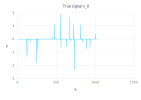

In [6]:
using Gadfly, Random

# random seed
Random.seed!(280)
# Size of signal
n = 1024
# Sparsity (# nonzeros) in the signal
s = 20
# Number of samples (undersample by a factor of 8) 
m = 128

# Generate and display the signal
x0 = zeros(n)
x0[rand(1:n, s)] = randn(s)
# Generate the random sampling matrix
A = randn(m, n) / m
# Subsample by multiplexing
y = A * x0

# plot the true signal
plot(x=1:n, y=x0, Geom.line, Guide.title("True signal x_0"))

### Solve LP by calling Gurobi directly (not recommended)

Gurobi model formulation:  
\begin{eqnarray*}
    &\text{minimize}& (1/2) x' H x + f' x \\
    &s.t.& A x \le b \\
    & & Aeq \cdot x = beq \\
    & & lb <= x <= ub
\end{eqnarray*}
Refer to [Gurobi.jl](https://github.com/JuliaOpt/Gurobi.jl) documentation for setting up the model.

Academic license - for non-commercial use only
Optimize a model with 128 rows, 2048 columns and 262144 nonzeros
Coefficient statistics:
  Matrix range     [1e-08, 3e-02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 1e-01]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 0.10s
Presolved: 128 rows, 2048 columns, 262144 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.128e+03
 Factor NZ  : 8.256e+03 (roughly 1 MByte of memory)
 Factor Ops : 7.073e+05 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.51327671e+03  0.00000000e+00  1.40e-14 0.00e+00  2.08e+00     0s
   1   4.36716581e+02  2.93300751e+00  1.90e-14 2.22e-15  2.12e-01     0s

Barrier performed 1 iterations in 0.16 seconds
Barrier solve interrupted - model solved by another algorit

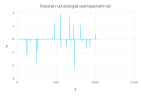

In [7]:
using Gurobi
env = Gurobi.Env()
setparams!(env, OutputFlag=1) # display log

# Construct the model
model = gurobi_model(env;
    name = "cs",
    f = ones(2 * n),
    Aeq = [A -A],
    beq = y,
    lb = zeros(2 * n))

# Run optimization
optimize(model)

# Show results
sol = get_solution(model)
xsol = sol[1:n] - sol[n + 1:end]

plot(x=1:n, y=x0, Geom.point)
plot(x=1:n, y=xsol, Geom.line, Guide.title("Reconstructed signal overlayed with x0"))

### Solve LP by DCP (disciplined convex programming) interface Convex.jl

Check [Convex.jl documentation](https://convexjl.readthedocs.io/en/latest/operations.html) for a list of supported operations.

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 2177            
  Cones                  : 0               
  Scalar variables       : 2049            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 1024
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.04    
Problem
  Name                   :                 
  Objective s

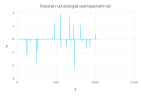

In [8]:
using Convex

# Use Mosek solver
using Mosek
solver = MosekSolver(LOG=1)

# # Use Gurobi solver
# using Gurobi
# solver = GurobiSolver(OutputFlag=1)

# # Use Cplex solver
# using CPLEX
# solver = CplexSolver(CPXPARAM_ScreenOutput=1)

## Use SCS solver
#using SCS
#solver = SCSSolver(verbose=1)
#set_default_solver(solver)

# Set up optimizaiton problem
x = Variable(n)
problem = minimize(norm(x, 1))
problem.constraints += A * x == y

# Solve the problem
@time solve!(problem, solver)

# Display the solution
plot(x=1:n, y=x0, Geom.point)
plot(x=1:n, y=xsol, Geom.line, Guide.title("Reconstructed signal overlayed with x0"))

## LP example: quantile regression

<img src="./growth-2-20-boys.png" width="300"/>
<img src="./quantregbin3.png" width="300"/>

* In linear regression, we model the mean of response variable as a function of covariates. In many situations, the error variance is not constant, the distribution of $y$ may be asymmetric, or we simply care about the quantile(s) of response variable. Quantile regression offers a better modeling tool in these applications.


* In $\tau$-quantile regression, we minimize the loss function
\begin{eqnarray*}
	f(\beta) = \sum_{i=1}^n \rho_\tau (y_i - \mathbf{x}_i^T \beta),
\end{eqnarray*}
where $\rho_\tau(z) = z (\tau - 1_{\{z < 0\}})$. Writing $\mathbf{y}  - \mathbf{X} \beta = \mathbf{r}^+ - \mathbf{r}^-$, this is equivalent to the LP
\begin{eqnarray*}
	&\text{minimize}& \tau \mathbf{1}^T \mathbf{r}^+ + (1-\tau) \mathbf{1}^T \mathbf{r}^- \\
	&\text{subject to}& \mathbf{r}^+ - \mathbf{r}^- = \mathbf{y} - \mathbf{X} \beta \\
	& & \mathbf{r}^+ \succeq \mathbf{0}, \mathbf{r}^- \succeq \mathbf{0}
\end{eqnarray*}
in $\mathbf{r}^+$, $\mathbf{r}^-$, and $\beta$.

## LP Example: $\ell_1$ regression

* A popular method in robust statistics is the median absolute deviation (MAD) regression that minimizes the $\ell_1$ norm of the residual vector $\|\mathbf{y} - \mathbf{X} \beta\|_1$. This apparently is equivalent to the LP
\begin{eqnarray*}
	&\text{minimize}& \mathbf{1}^T (\mathbf{r}^+ + \mathbf{r}^-) \\
	&\text{subject to}& \mathbf{r}^+ - \mathbf{r}^- = \mathbf{y} - \mathbf{X} \beta \\
	& & \mathbf{r}^+ \succeq \mathbf{0}, \mathbf{r}^- \succeq \mathbf{0}
\end{eqnarray*}
in $\mathbf{r}^+$, $\mathbf{r}^-$, and $\beta$. 

    $\ell_1$ regression = MAD = 1/2-quantile regression.

## LP Example: $\ell_\infty$ regression (Chebychev approximation)

* Minimizing the worst possible residual $\|\mathbf{y} - \mathbf{X} \beta\|_\infty$ is equivalent to the LP
\begin{eqnarray*}
	&\text{minimize}& t \\
	&\text{subject to}& -t \le y_i - \mathbf{x}_i^T \beta \le t, \quad i = 1,\dots,n
\end{eqnarray*}
in variables $\beta$ and $t$.

## LP Example: Dantzig selector

* [Candes and Tao (2007)](https://www.doi.org/10.1214/009053606000001523) propose a variable selection method called the Dantzig selector that solves
\begin{eqnarray*}
	&\text{minimize}& \|\mathbf{X}^T (\mathbf{y} - \mathbf{X} \beta)\|_\infty \\
	&\text{subject to}& \sum_{j=2}^p |\beta_j| \le t,
\end{eqnarray*}
which can be transformed to an LP. Indeed they name the method after George Dantzig, who invented the simplex method for efficiently solving LP in 50s.

<img src="./george-bernard-dantzig.jpg" width="300"/>

## LP Example: 1-norm SVM

* In two-class classification problems, we are given training data $(\mathbf{x}_i, y_i)$, $i=1,\ldots,n$, where $\mathbf{x}_i \in \mathbb{R}^p$ are feature vectors and $y_i \in \{-1, 1\}$ are class labels. [Zhu, Rosset, Tibshirani, and Hastie (2004)](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwi-_6C2sMLiAhUNGDQIHU1RD3MQFjAAegQIBRAC&url=https%3A%2F%2Fpapers.nips.cc%2Fpaper%2F2450-1-norm-support-vector-machines.pdf&usg=AOvVaw1cTOsmPjpxKJHCs93iLUkn) propose the 1-norm support vector machine (svm) that achieves the dual purpose of classification and feature selection. Denote the solution of the optimization problem
\begin{eqnarray*}
	&\text{minimize}& \sum_{i=1}^n \left[ 1 - y_i \left( \beta_0 + \sum_{j=1}^p x_{ij} \beta_j \right) \right]_+ \\
	&\text{subject to}& \|\beta\|_1 = \sum_{j=1}^p |\beta_j| \le t
\end{eqnarray*}
by $\hat \beta_0(t)$ and $\hat \beta(t)$. 1-norm svm classifies a future feature vector $\mathbf{x}$ by the sign of fitted model
\begin{eqnarray*}
	\hat f(\mathbf{x}) = \hat \beta_0 + \mathbf{x}^T \hat \beta.
\end{eqnarray*}

Many more applications of LP: Airport scheduling (Copenhagen airport uses Gurobi), airline flight scheduling, NFL scheduling, match.com, $\LaTeX$, ...

Apparently any loss/penalty or loss/constraint combinations of form 
$$
\{\ell_1, \ell_\infty, \text{quantile}\} \times \{\ell_1, \ell_\infty, \text{quantile}\},
$$
possibly with affine (equality and/or inequality) constraints, can be formulated as an LP.